In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

## Reading and understanding data

In [3]:
df =pd.read_csv("./mental_health.csv",index_col=0)

In [4]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


Remove missing data-

In [7]:
df.isna().sum()

statement    362
status         0
dtype: int64

In [8]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

In [9]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

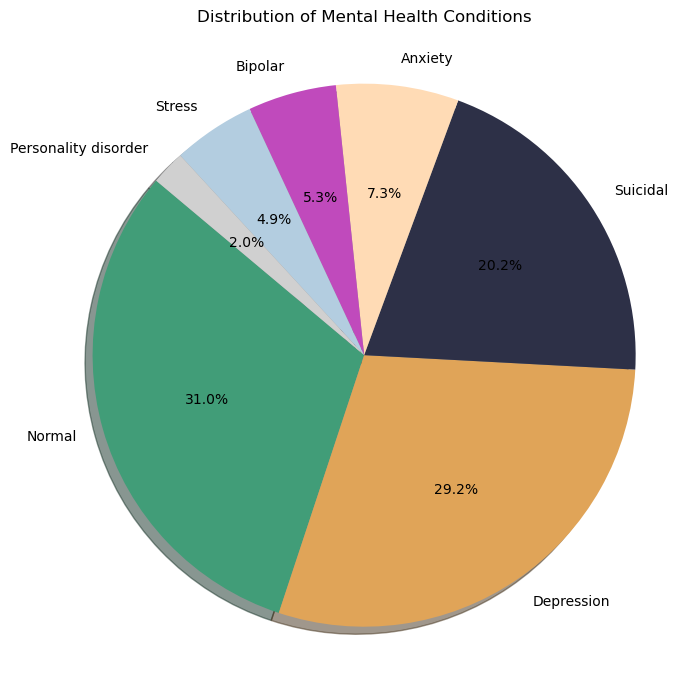

In [10]:
status_counts = df['status'].value_counts()

colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal') 

plt.tight_layout()
plt.show()

In [11]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Is my (30s F) anxiety screwing with me or am I correctly interpreting that this woman (30s F) is not interested in being friends with me? I'm (30s F) feeling hurt by this interaction with a friend of a friend (also 30s F) who I thought might want to be friends with me (but evidently doesn't) and need help processing it/some feedback on it. On top of my social anxiety, I have other anxiety disorders, depression and am possibly on the spectrum so socializing is extra extra hard for me and I really am lacking in friends.

Here's the situation:

**July 2019:** Was at a friend's wedding out of state and met one of her other friends who lives in my state, about 30-40 min away from me. We hit it off and she said she's always looking for new friends and it would be cool to grab dinner sometime.

**Dec 2019:** I never hear from her and reach out to find out about dinner and we schedule something, but end up canceling because she has a family emergency.

**Feb 2020:** 

In [12]:
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

description = df[['num_of_characters', 'num_of_sentences']].describe()

print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


Several lengthy messages


In [13]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


## Text Preprocessing

Lowercasing-

In [14]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


Removing URLs, handles, punctuation and special characters

In [15]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


Tokenization

In [16]:
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


Stemming(reducing words to their base or root form)-

In [17]:
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


Word clouds

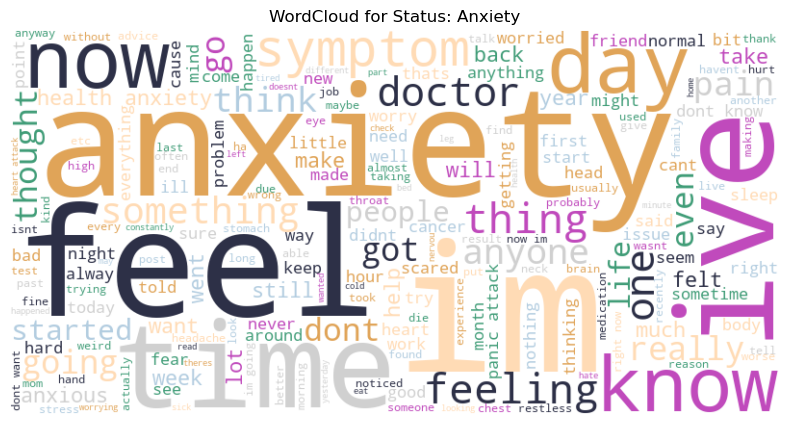

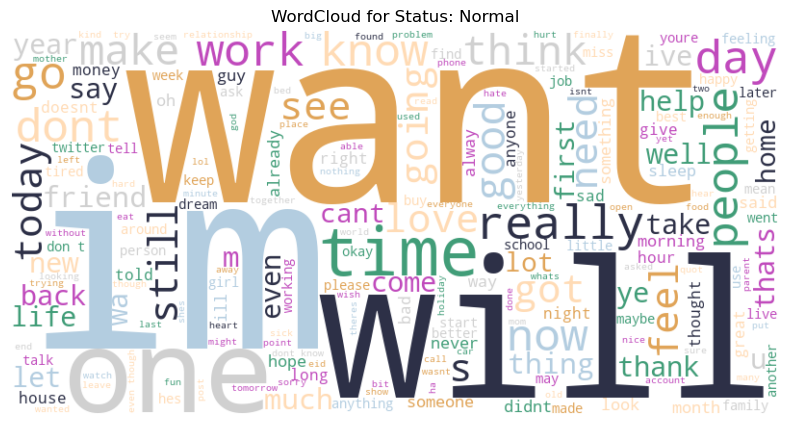

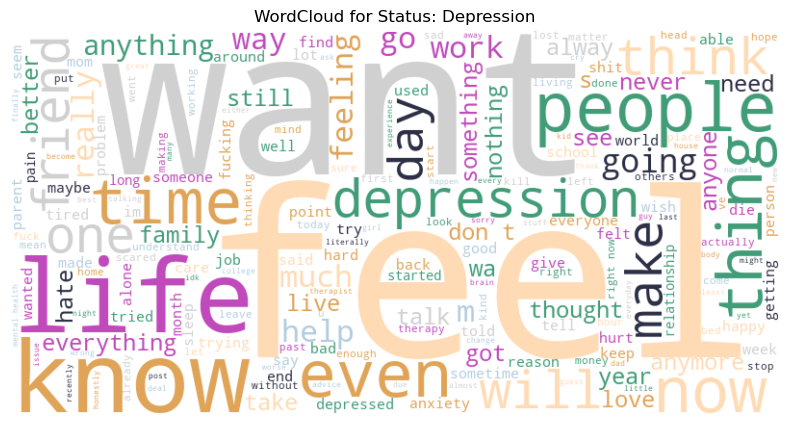

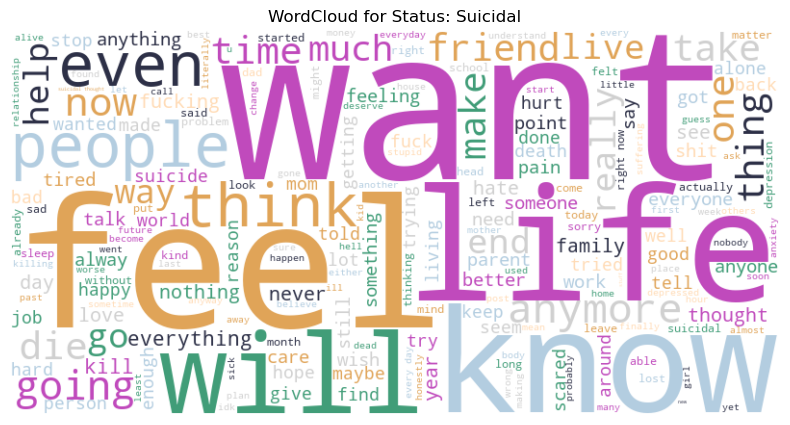

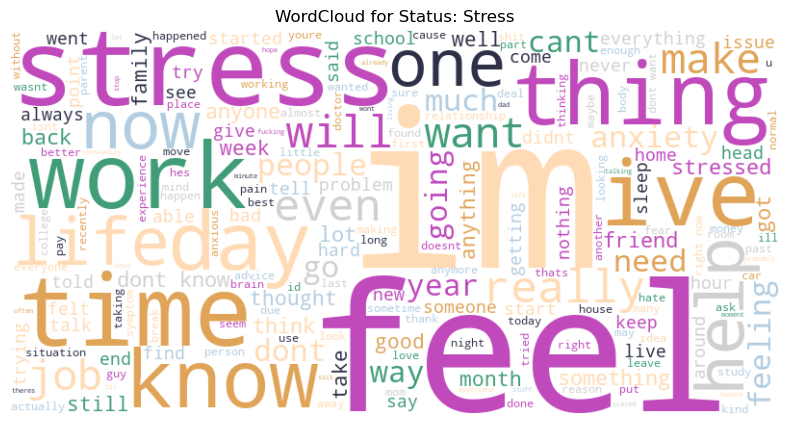

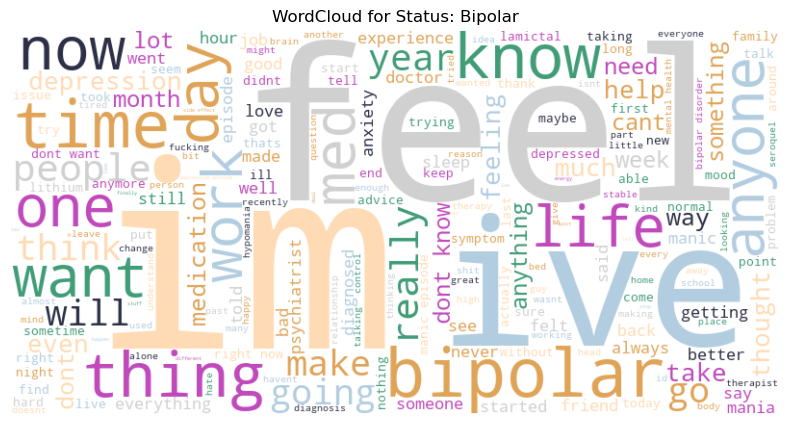

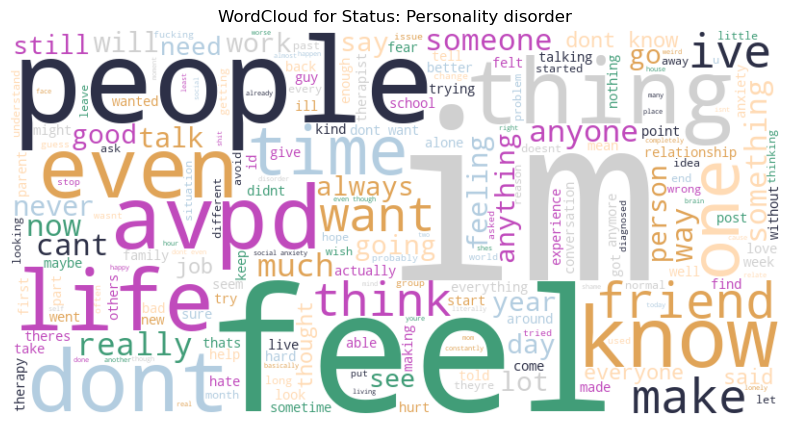

In [18]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)
# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

Significant overlap in the language used for discussing depression and suicidal thoughts.

## Data Preprocessing

Separate features and labels

In [19]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

Label encoding target variable

In [20]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

Split the data into training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

Convert text to features using TF-IDF vectoriser

In [22]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [23]:
X_train_combined.shape

(42144, 50002)

Resampling 

In [24]:
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [25]:
X_train_resampled.shape


(91742, 50002)

## Model Training and Evaluation

In [26]:
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='hist')
}



For Bernoulli Naive Bayes
Accuracy: 0.6405997912119199
                      precision    recall  f1-score   support

             Anxiety       0.67      0.60      0.63       768
             Bipolar       0.70      0.58      0.64       566
          Depression       0.66      0.48      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.87      0.33      0.48       202
              Stress       0.42      0.52      0.47       530
            Suicidal       0.59      0.53      0.56      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



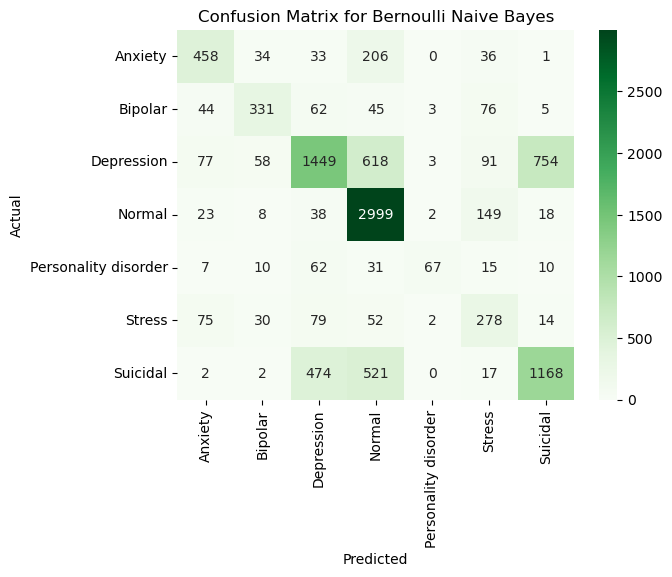

✅ Model saved as Bernoulli_Naive_Bayes_model.pkl


For Decision Tree
Accuracy: 0.6175381987282907
                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.46      0.63      0.53       566
          Depression       0.79      0.34      0.48      3050
              Normal       0.87      0.85      0.86      3237
Personality disorder       0.51      0.47      0.48       202
              Stress       0.24      0.80      0.37       530
            Suicidal       0.52      0.65      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.58      0.61      0.56     10537
        weighted avg       0.70      0.62      0.62     10537



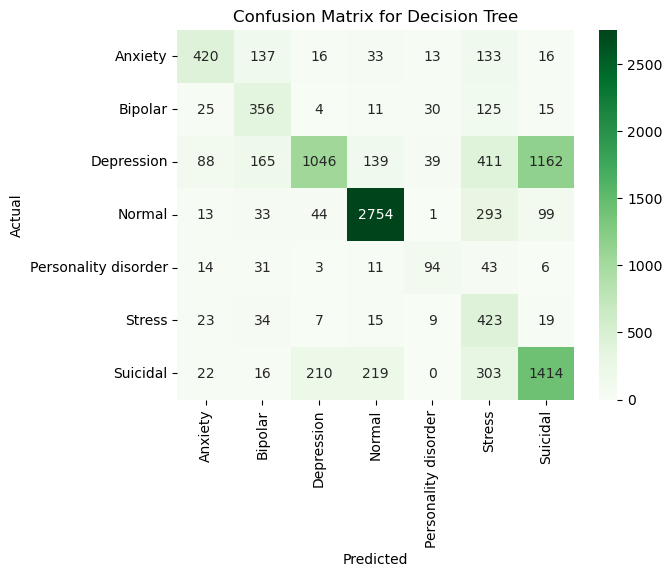

✅ Model saved as Decision_Tree_model.pkl


For Logistic Regression
Accuracy: 0.7653981209072791
                      precision    recall  f1-score   support

             Anxiety       0.78      0.81      0.80       768
             Bipolar       0.84      0.80      0.82       566
          Depression       0.72      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.71      0.64      0.68       202
              Stress       0.59      0.65      0.62       530
            Suicidal       0.65      0.68      0.67      2184

            accuracy                           0.77     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.77      0.77      0.76     10537



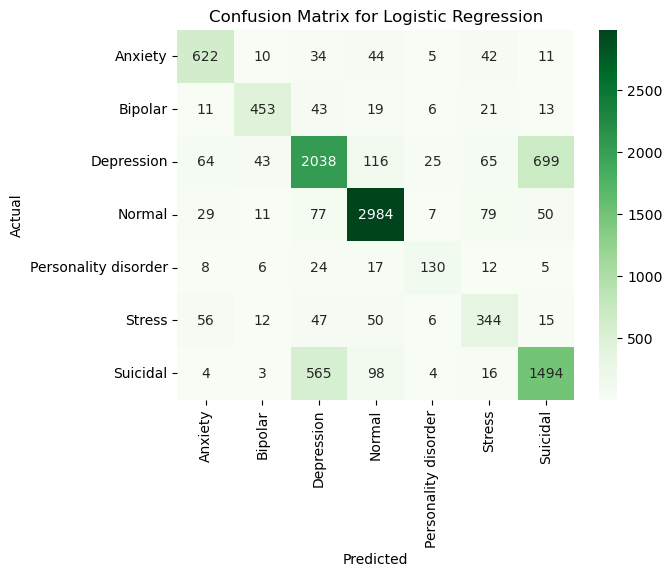

✅ Model saved as Logistic_Regression_model.pkl


For XGB
Accuracy: 0.8074404479453355
                      precision    recall  f1-score   support

             Anxiety       0.83      0.87      0.85       768
             Bipolar       0.87      0.82      0.85       566
          Depression       0.78      0.73      0.75      3050
              Normal       0.92      0.93      0.93      3237
Personality disorder       0.82      0.66      0.73       202
              Stress       0.67      0.76      0.71       530
            Suicidal       0.69      0.73      0.71      2184

            accuracy                           0.81     10537
           macro avg       0.80      0.79      0.79     10537
        weighted avg       0.81      0.81      0.81     10537



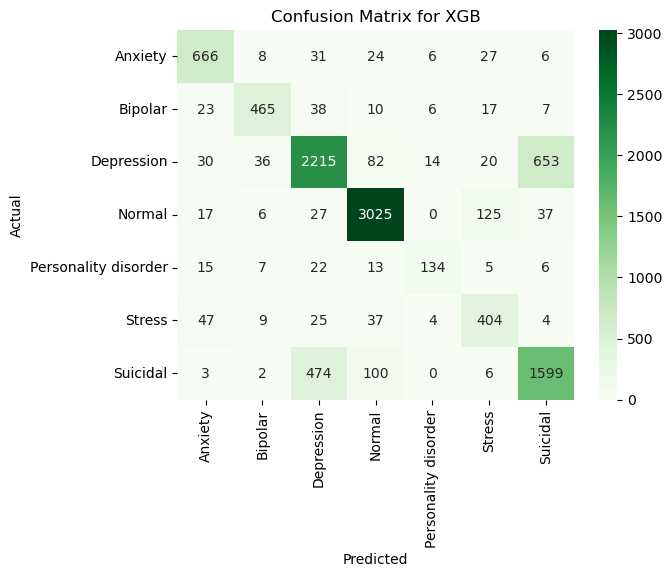

✅ Model saved as XGB_model.pkl

✅ All models, vectorizer, and label encoder saved successfully!


In [27]:
import joblib  

accuracy_scores = []


for name, clf in classifiers.items():
    # Train model
    clf.fit(X_train_resampled, y_train_resampled)
    
    # Predict
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Confusion matrix heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  
    plt.ylabel('Actual')   
    plt.title(f'Confusion Matrix for {name}')  
    plt.show() 
    
    # Save the trained model
    model_filename = f"{name.replace(' ', '_')}_model.pkl"
    joblib.dump(clf, model_filename)
    print(f"✅ Model saved as {model_filename}")
    
    # Append accuracy
    accuracy_scores.append(accuracy)


joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(lbl_enc, "label_encoder.pkl")
print("\n✅ All models, vectorizer, and label encoder saved successfully!")


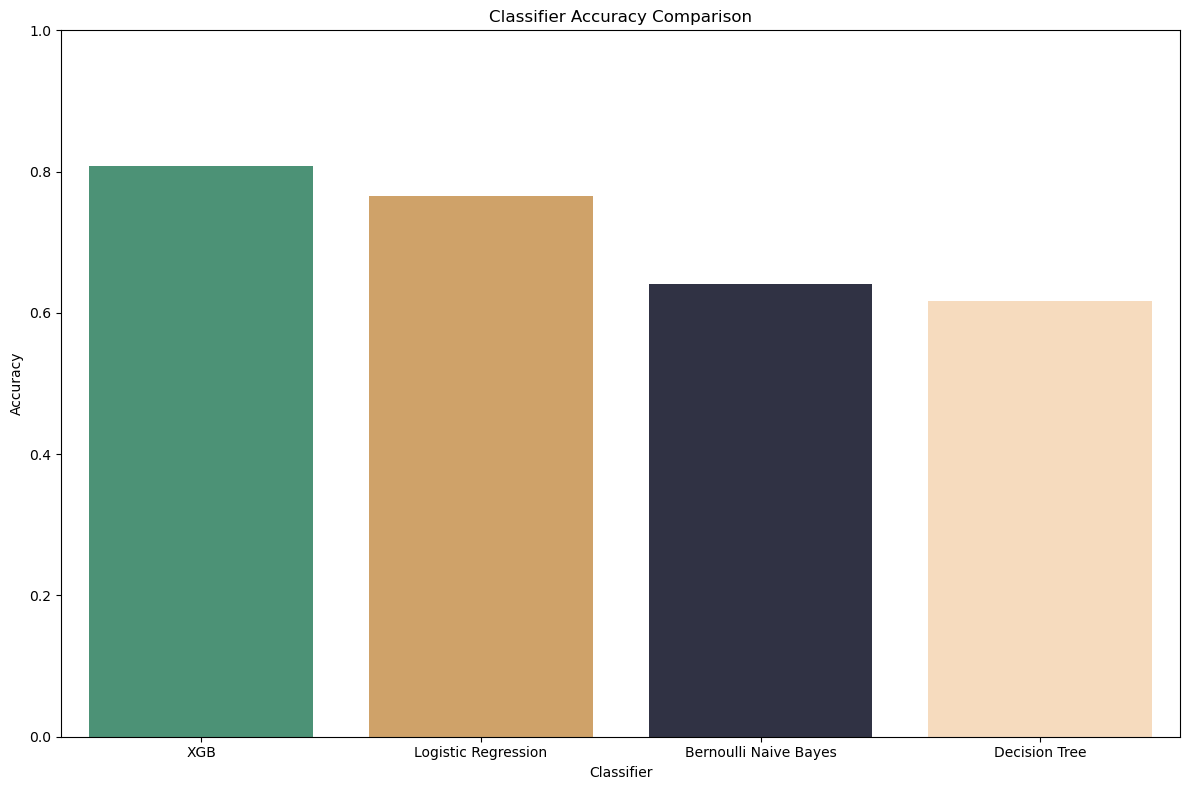

In [28]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

We evaluated four models designed to handle large datasets with numerous features: Bernoulli Naive Bayes, Decision Tree, Logistic Regression, and XGBoost (XGB). XGBoost emerged as the top performer with an accuracy of 81%. The classification report showed that the Normal state was the easiest to distinguish with an F1 score of 93, followed by Anxiety and Bipolar with F1 scores of 85. Other states also performed well, with F1 scores above 70. Although the Confusion Matrix and WordCloud analysis revealed some overlap between depression and suicidal messages, XGBoost still outperformed the other models and demonstrated superior overall performance.

In [29]:
model = joblib.load("XGB_model.pkl")  # change name for other models
vectorizer = joblib.load("tfidf_vectorizer.pkl")
lbl_enc = joblib.load("label_encoder.pkl")

In [30]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    stemmed = ' '.join(stemmer.stem(token) for token in tokens)
    
    num_chars = len(text)
    num_sents = len(nltk.sent_tokenize(text))
    
    return stemmed, num_chars, num_sents


In [50]:
test_statements = [
    "I’m totally fine, don’t worry about me.",
    "Yup, I’m absolutely thriving while losing sleep and sanity.",
    "My mind feels blank and I can't focus on anything.",
    "Oh yes, being constantly anxious is my favorite hobby.",
    "I don’t know why my moods change so suddenly."
]


In [51]:
def predict_status(statements, model, vectorizer, lbl_enc):
    results = []
    for text in statements:
        stemmed, chars, sents = preprocess_text(text)
        
        # TF-IDF + numeric features
        tfidf_features = vectorizer.transform([stemmed])
        num_features = np.array([[chars, sents]])
        combined_features = hstack([tfidf_features, num_features])
        
        # Predict
        pred = model.predict(combined_features)
        label = lbl_enc.inverse_transform(pred)[0]
        results.append((text, label))
    
    return results


In [52]:
predictions = predict_status(test_statements, model, vectorizer, lbl_enc)

for text, label in predictions:
    print(f"\n Statement: {text}\n Predicted Status: {label}")



 Statement: I’m totally fine, don’t worry about me.
 Predicted Status: Anxiety

 Statement: Yup, I’m absolutely thriving while losing sleep and sanity.
 Predicted Status: Normal

 Statement: My mind feels blank and I can't focus on anything.
 Predicted Status: Normal

 Statement: Oh yes, being constantly anxious is my favorite hobby.
 Predicted Status: Anxiety

 Statement: I don’t know why my moods change so suddenly.
 Predicted Status: Normal
